In [1]:
pip install lime

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.pipeline import make_pipeline
from lime import lime_text
from lime.lime_text import LimeTextExplainer

# Simulate chest X-ray reports
def generate_report(category):
    reports = {
        'normal': ["Chest X-ray shows clear lung fields. No evidence of consolidation, effusion, or pneumothorax. Heart size within normal limits. No acute cardiopulmonary abnormality.",
                   "Lungs are clear bilaterally. No focal consolidation, pneumothorax, or pleural effusion. Cardiomediastinal silhouette is unremarkable. Osseous structures are intact."],
        'pneumonia': ["Patchy opacity in the right lower lobe consistent with pneumonia. No pleural effusion or pneumothorax. Heart size normal.",
                      "Left lower lobe consolidation suggestive of pneumonia. No effusion or pneumothorax. Cardiac silhouette within normal limits."],
        'cardiomegaly': ["Enlarged cardiac silhouette consistent with cardiomegaly. Lung fields are clear. No pleural effusion or pneumothorax.",
                         "Cardiomegaly present with cardiothoracic ratio > 0.5. No focal consolidation or effusion. Lung volumes are normal."],
        'effusion': ["Small right pleural effusion noted. No evidence of pneumothorax or consolidation. Heart size is normal.",
                     "Bilateral pleural effusions, left greater than right. No focal consolidation. Mild cardiomegaly present."]
    }
    return np.random.choice(reports[category])

# Generate simulated dataset
categories = ['normal', 'pneumonia', 'cardiomegaly', 'effusion']
X = []
y = []
for i, category in enumerate(categories):
    for _ in range(100):  # Generate 100 reports per category
        X.append(generate_report(category))
        y.append(i)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

# Make predictions
y_pred = rf.predict(X_test_vec)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

# Create a pipeline
c = make_pipeline(vectorizer, rf)

# LIME explainer
explainer = LimeTextExplainer(class_names=categories)

# Explain a prediction
idx = 0  # Choose an index to explain
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=len(categories))

print('\nExplanation for Report', idx)
print('True class:', categories[y_test[idx]])
for i, class_name in enumerate(categories):
    print(f'Probability({class_name}) =', c.predict_proba([X_test[idx]])[0, i])

# Show the explanation
print("\nFeatures contributing to the prediction:")
print(exp.as_list())

# To visualize the explanation, you would typically use:
# fig = exp.as_pyplot_figure()
# fig.show()
# However, this may not work in all environments, so we'll skip it for now

Mean Absolute Error: 0.0

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00        26
   pneumonia       1.00      1.00      1.00        18
cardiomegaly       1.00      1.00      1.00        18
    effusion       1.00      1.00      1.00        18

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


Explanation for Report 0
True class: cardiomegaly
Probability(normal) = 0.0
Probability(pneumonia) = 0.0
Probability(cardiomegaly) = 1.0
Probability(effusion) = 0.0

Features contributing to the prediction:
[('Cardiomegaly', -0.03707723125408073), ('Lung', -0.028639370177388348), ('consolidation', -0.009234839222963653), ('focal', -0.008021691497031714), ('effusion', -0.007105919481399862), ('ratio', -0.006043468566183171)]


In [3]:
exp.show_in_notebook(text=False)

In [4]:
pip install shap


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Mean Absolute Error: 0.0

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00        26
   pneumonia       1.00      1.00      1.00        18
cardiomegaly       1.00      1.00      1.00        18
    effusion       1.00      1.00      1.00        18

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



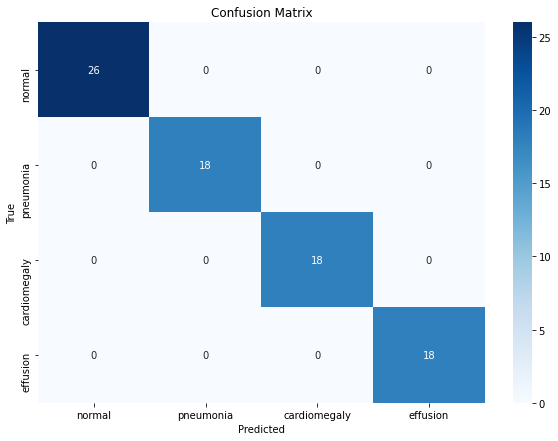

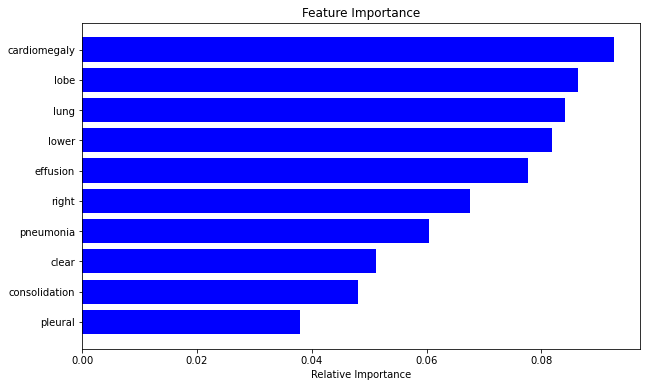

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import shap

# Simulate chest X-ray reports
def generate_report(category):
    reports = {
        'normal': ["Chest X-ray shows clear lung fields. No evidence of consolidation, effusion, or pneumothorax. Heart size within normal limits. No acute cardiopulmonary abnormality.",
                   "Lungs are clear bilaterally. No focal consolidation, pneumothorax, or pleural effusion. Cardiomediastinal silhouette is unremarkable. Osseous structures are intact."],
        'pneumonia': ["Patchy opacity in the right lower lobe consistent with pneumonia. No pleural effusion or pneumothorax. Heart size normal.",
                      "Left lower lobe consolidation suggestive of pneumonia. No effusion or pneumothorax. Cardiac silhouette within normal limits."],
        'cardiomegaly': ["Enlarged cardiac silhouette consistent with cardiomegaly. Lung fields are clear. No pleural effusion or pneumothorax.",
                         "Cardiomegaly present with cardiothoracic ratio > 0.5. No focal consolidation or effusion. Lung volumes are normal."],
        'effusion': ["Small right pleural effusion noted. No evidence of pneumothorax or consolidation. Heart size is normal.",
                     "Bilateral pleural effusions, left greater than right. No focal consolidation. Mild cardiomegaly present."]
    }
    return np.random.choice(reports[category])

# Generate simulated dataset
categories = ['normal', 'pneumonia', 'cardiomegaly', 'effusion']
X = []
y = []
for i, category in enumerate(categories):
    for _ in range(100):  # Generate 100 reports per category
        X.append(generate_report(category))
        y.append(i)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

# Make predictions
y_pred = rf.predict(X_test_vec)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features
features = vectorizer.get_feature_names()

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()




Mean Absolute Error: 0.75

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      0.54      0.70        26
   pneumonia       0.00      0.00      0.00        18
cardiomegaly       0.27      1.00      0.43        18
    effusion       0.00      0.00      0.00        18

    accuracy                           0.40        80
   macro avg       0.32      0.38      0.28        80
weighted avg       0.39      0.40      0.32        80



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


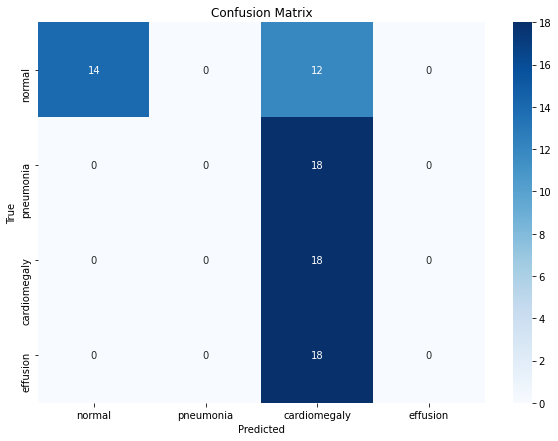

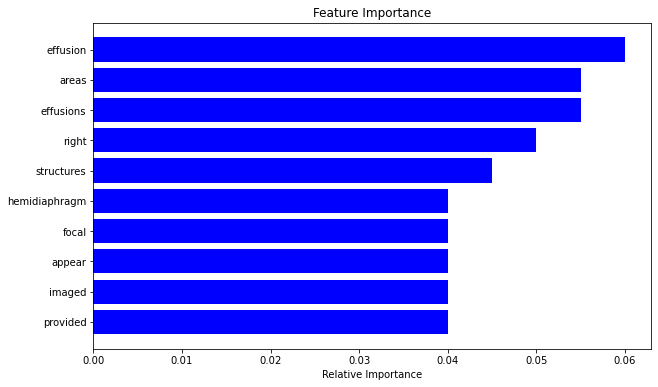

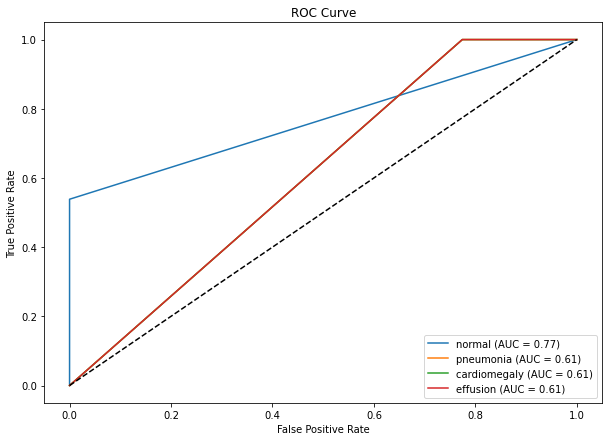

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Simulate chest X-ray reports
def generate_report(category):
    reports = {
        'normal': ["No focal areas of consolidation. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Osseous structures appear intact",
                   "pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen."],
        'pneumonia': ["pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen.",
                      "pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen."],
        'cardiomegaly': ["pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen.",
                         "pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen."],
        'effusion': ["pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen.",
                     "pa and lateral views of the chest provided. there is no focal consolidation, effusion, or pneumothorax. the cardiomediastinal silhouette is normal. imaged osseous structures are intact. no free air below the right hemidiaphragm is seen."]
    }
    return np.random.choice(reports[category])

# Generate simulated dataset
categories = ['normal', 'pneumonia', 'cardiomegaly', 'effusion']
X = []
y = []
for i, category in enumerate(categories):
    for _ in range(100):  # Generate 100 reports per category
        X.append(generate_report(category))
        y.append(i)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

# Make predictions
y_pred = rf.predict(X_test_vec)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features
features = vectorizer.get_feature_names()

plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


# One-vs-Rest ROC Curve and AUC for each class
plt.figure(figsize=(10, 7))
for i, category in enumerate(categories):
    # One-vs-rest approach
    y_test_bin = np.array([1 if label == i else 0 for label in y_test])
    y_pred_prob = rf.predict_proba(X_test_vec)[:, i]
    fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
    auc_score = roc_auc_score(y_test_bin, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{category} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



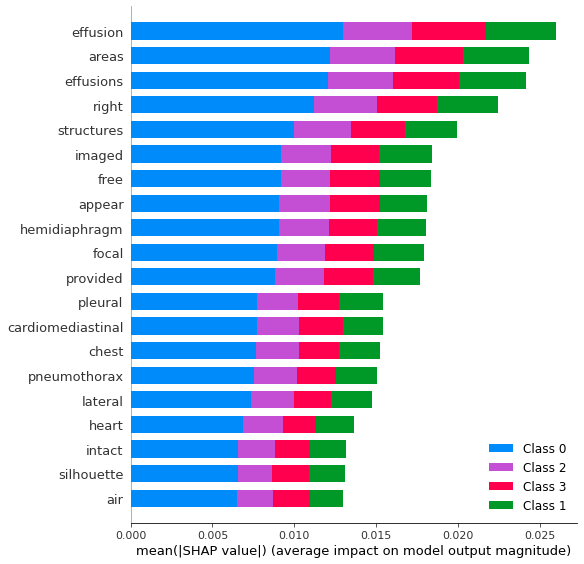

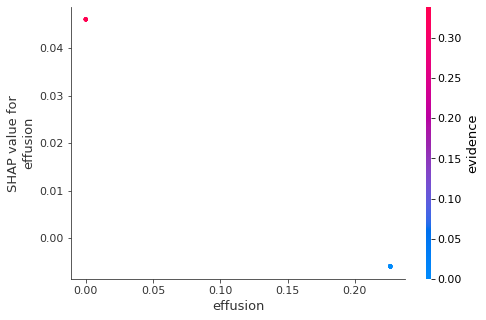

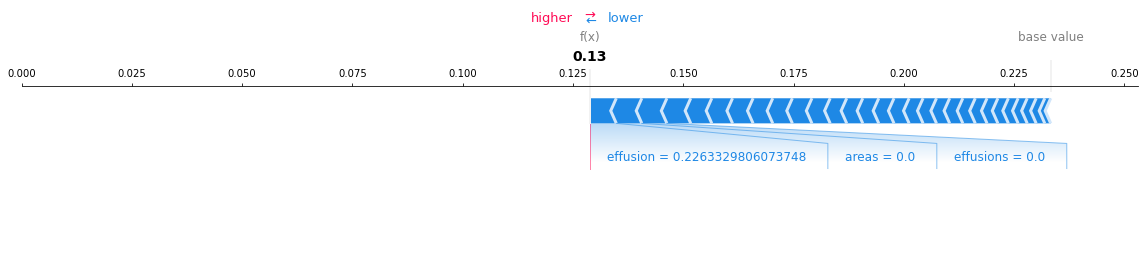

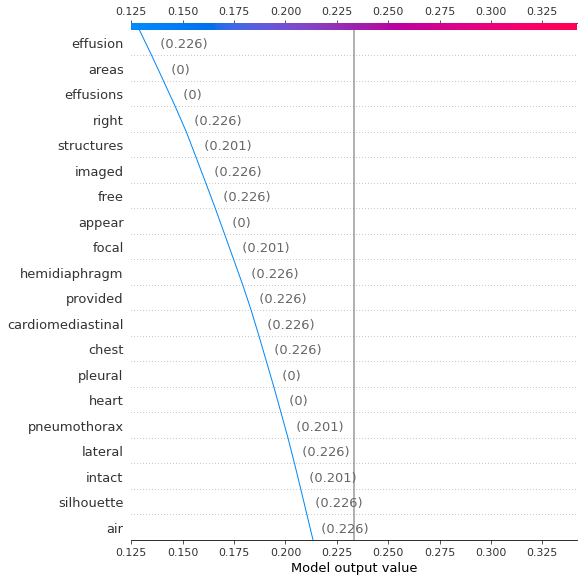

In [7]:
# Convert sparse matrices to dense arrays
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

# Create the SHAP explainer
explainer = shap.TreeExplainer(rf)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_dense)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_dense, feature_names=features)

# SHAP dependence plot for the most important feature
most_important_feature = np.argmax(importances)
shap.dependence_plot(most_important_feature, shap_values[0], X_test_dense, 
                     feature_names=features)

# SHAP force plot for a single prediction (e.g., the first test sample)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test_dense[0], 
                feature_names=features, matplotlib=True)

# SHAP decision plot
shap.decision_plot(explainer.expected_value[0], shap_values[0][0], X_test_dense[0], 
                   feature_names=features)

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Simulate chest X-ray reports
def generate_report(category):
    reports = {
        'normal': ["No focal areas of consolidation. Heart size within normal limits. No pleural effusions. No evidence of pneumothorax. Osseous structures appear intact",
                   "XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen."],
        'pneumonia': ["XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.",
                      "XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen."],
        'cardiomegaly': ["XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.",
                         "XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen."],
        'effusion': ["XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.",
                     "XXXX XXXX representing the XXXX XXXX are present. The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen."]
    }
    return np.random.choice(reports[category])
categories = ['normal', 'pneumonia', 'cardiomegaly', 'effusion']
X = []
y = []
for i, category in enumerate(categories):
    for _ in range(100):  # Generate 100 reports per category
        X.append(generate_report(category))
        y.append(i)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_vec, y_train)

# Make predictions
y_pred = rf.predict(X_test_vec)

# Evaluate the model
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

# Create a pipeline
c = make_pipeline(vectorizer, rf)

# LIME explainer
explainer = LimeTextExplainer(class_names=categories)

# Explain a prediction
idx = 0  # Choose an index to explain
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=len(categories))

print('\nExplanation for Report', idx)
print('True class:', categories[y_test[idx]])
for i, class_name in enumerate(categories):
    print(f'Probability({class_name}) =', c.predict_proba([X_test[idx]])[0, i])

# Show the explanation
print("\nFeatures contributing to the prediction:")
for feature, contribution in exp.as_list():
    print(f"{feature}: {contribution}")

exp.show_in_notebook(text=False)

Mean Absolute Error: 0.8

Classification Report:
               precision    recall  f1-score   support

      normal       1.00      0.46      0.63        26
   pneumonia       0.00      0.00      0.00        18
cardiomegaly       0.26      1.00      0.42        18
    effusion       0.00      0.00      0.00        18

    accuracy                           0.38        80
   macro avg       0.32      0.37      0.26        80
weighted avg       0.38      0.38      0.30        80



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Explanation for Report 0
True class: cardiomegaly
Probability(normal) = 0.13730843282459587
Probability(pneumonia) = 0.2859164829357511
Probability(cardiomegaly) = 0.29034320844705186
Probability(effusion) = 0.2864318757926014

Features contributing to the prediction:
limits: 0.028472788069162418
pulmonary: 0.026825283236091346
pneumothorax: 0.026206491605593178
present: 0.022128311515436736
effusion: 0.021985027839463024
free: 0.021945401367351777
